# Numerical differentiation

This section focuses on ways to numerically approximate the derivative of a function $f(x)$ with respect to an independent variable $x$. If we know $f$ explicitly we can use symbolic manipulations find $f'=\frac{\text{d}f}{\text{d}x}$. Let's say that instead we only have data $f(x_n)$ sampled at $N$ points $x_0,x_1,...,x_n,...,x_{N-1}$. Taylor expanding $f$ at a point $x_n+h$ close to a given node $x_n$,

\begin{equation}
    f(x_n+h)=f(x_n) + hf'(x_n) + \frac{1}{2}h^2f''(x_n) + \mathcal{O}(h^3)
\end{equation}


Taking $h$ to be the separation between successive grid points, ``finite difference'' methods use taylor expansions to approximate derivatives with an error that scales with some power $h$. For example, the first order forward finite difference approximation writes

\begin{equation}
    f'(x_n)=\frac{1}{h}[f(x_n+h)-f(x_n)] + \mathcal{O}(h).
\end{equation}

Similarly, we might write

\begin{equation}
    f'(x_n)=\frac{1}{h}[f(x_n)-f(x_n-h)] + \mathcal{O}(h).
\end{equation}

Unfortunately, both forward and backward finite differences perform poorly. A better approach is to combine the Taylor expansions for $f(x_n+h)$ and $f(x_n-h)$ to produce the "centred'' finite difference approximation

\begin{equation}
    f'(x_n)=\frac{1}{2h}[f(x_n+h)-f(x_n-h)] +  \mathcal{O}(h^2).
\end{equation}

Of course we can't apply this formula to the endpoints $x_0$ and $x_{N-1}$ of the grid, since there we don't have $x_n-h$ and $x_n+h$ (respectively). The following function applies this centred differences approximation on interior points, and forward/backward approximations on the endpoints:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})

def fundiff(ff,xx):
    '''
        computes the second-order finite differences approximation to the derivative of a 
        function f with values sampled at a grid-points xx, assuming that the grid-points
        in xx are evenly spaced
    '''
    # compute array of grid-spacing h, and check that xx are all evenly spaced:
    hh = xx[1] - xx[0]
    if np.any(abs(np.diff(xx) - hh)>1e-14):
        raise ValueError('expected evenly spaced grid')
    
    # initialize array to hold derivative values:
    dfdx = np.zeros_like(ff)
    
    # use centred differences to compute derivatives at interior points:
    dfdx[1:-1] = (ff[2:] - ff[:-2])/hh/2.
    
    # apply forward/backward formulae at endpoints:
    dfdx[0] = (ff[1] - ff[0])/hh
    dfdx[-1]= (ff[-1]- ff[-2])/hh
    return dfdx

Because this function applies a less accurate finite difference approximation at the boundaries, we expect the error to be larger there.

In [3]:
xx = np.linspace(0,1,100)
ff = np.cos(20*xx)*np.exp(-2*xx)
dfdx = -20*np.sin(20*xx)*np.exp(-2*xx) - 2*np.cos(20*xx)*np.exp(-2*xx)

The numpy function np.gradient uses much the same approach as above:

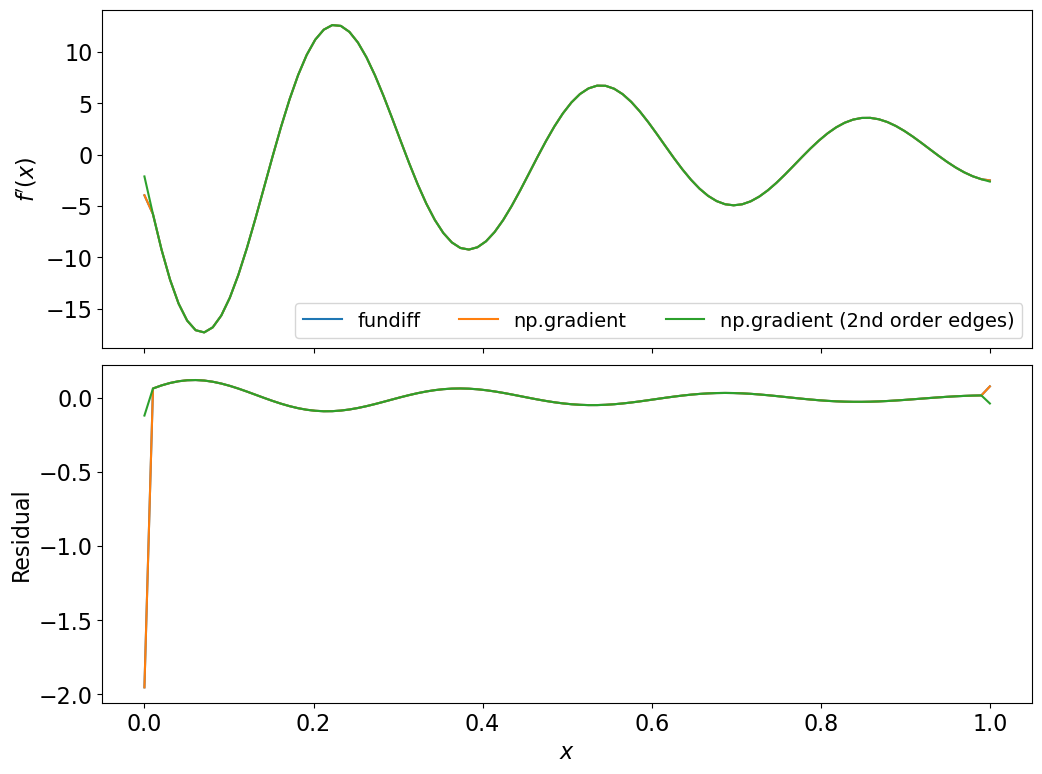

In [4]:
f,ax = plt.subplots(2,1,figsize=(12,9),sharex=True)
ax[0].plot(xx,fundiff(ff,xx),label='fundiff')
ax[0].plot(xx,np.gradient(ff,xx),label='np.gradient')
ax[0].plot(xx,np.gradient(ff,xx,edge_order=2),label='np.gradient (2nd order edges)')
ax[1].plot(xx,fundiff(ff,xx)-dfdx)
ax[1].plot(xx,np.gradient(ff,xx)-dfdx)
ax[1].plot(xx,np.gradient(ff,xx,edge_order=2)-dfdx)
ax[1].set_xlabel('$x$')
ax[0].set_ylabel("$f'(x)$")
ax[1].set_ylabel('Residual')
ax[0].legend(ncol=3,fontsize=14)
plt.subplots_adjust(hspace=0.05)

## Exercise 4

The second-order, forward, centred, and backward finite difference approximations for the \emph{second} derivatives of a function are
\begin{align}
    f''(x)
    &\simeq\frac{1}{h^2}[f(x + 2h) -2 f(x+h) + f(x)] \hspace{2em} \text{(forward)},
\\
    &\simeq\frac{1}{h^2}[f(x + h) -2f(x) + f(x - h)] \hspace{2em} \text{(centred)},
\\
    &\simeq\frac{1}{h^2}[f(x) - 2 f(x -h) + f(x - 2h)] \hspace{2em} \text{(backward)}.
\end{align}
Write a function that computes the second derivative of a function sampled at grid-points with a user-supplied constant separation h. Test it on the function considered above, and compare with the analytical solution.

# Spectral methods

Finite difference methods can be extended to higher orders in accuracy, but they are far from the only approach to computing numerical derivatives. Spectral methods take the approach of expanding a function as

\begin{equation}
    f(x) = \sum_j c_j \phi_j(x),
\end{equation}

where $c_j$ are constant coefficients, and $\phi_j(x)$ are "basis" (i.e., magical) functions satisfying the same boundary conditions as $f$. If the coefficients $c_j$ are known, then $f'(x)$ can be computed from the basis functions as

\begin{equation}
    f'(x) = \sum_j c_j \phi_j'(x).
\end{equation}

## Example 5

Suppose $f(x)$ is periodic on the domain of interest. Then the appropriate choice of $\phi_j$ would be Fourier modes:

\begin{equation}
    f=\sum_{n=-\infty}^\infty c_n \exp[\text{i}n x]
     =\sum_{n=-\infty}^\infty c_n[\cos(n x) + \text{i}\sin(nx)],
\end{equation}

and so 

\begin{equation}
    f'=\sum_{n=-\infty}^\infty \text{i}nc_n \exp[\text{i}n x]
     =\sum_{n=-\infty}^\infty nc_n[\text{i}\cos(n x) - \sin(nx)],
\end{equation}

where $c_n$ are (potentially complex-valued) coefficients that can be determined using fast Fourier transforms:

\begin{equation}
    c_n
    \simeq
    \frac{1}{N}\sum_{k=0}^{N-1}f(x_k)\exp\left[\frac{-2\pi\text{i} nk}{N}\right],
\end{equation}

for $f$ sampled on the $N$ grid-points $x_0,...,x_{N-1}$. The following function differentiates a periodic function using Fourier transforms:

In [5]:
from scipy.fft import fft,fftshift

def dfft(ff,xx):
    N = xx.size
    cn= fftshift(fft(ff)*2*np.pi/N) # fftshift "unwraps" a Nyquist shift introduced by fft
    nn= np.arange(N) - int(N/2)
    
    # create 2D meshes of grid-points and indices/coefficients (not strictly 
    # necessary, but it makes the following reconstruction easier):
    X,Nn = np.meshgrid(xx,nn,indexing='ij')
    Cn = np.meshgrid(xx,cn,indexing='ij')[1]
        
    # compute derivative:
    dfdx = np.sum(1.j*Nn*Cn*np.exp(2.j*np.pi*X*Nn),axis=1)
    return dfdx

This approach works much better than finite differences, but only when the sampled function is periodic:

In [6]:
xx = np.linspace(0,1,1000,endpoint=False)

ff = np.cos(5*2*np.pi*xx)*np.sin(3*2*np.pi*xx)
dfdx= -10*np.pi*np.sin(10*np.pi*xx)*np.sin(6*np.pi*xx) \
      +6* np.pi*np.cos(10*np.pi*xx)*np.cos(6*np.pi*xx)

/home/janosz/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/janosz/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


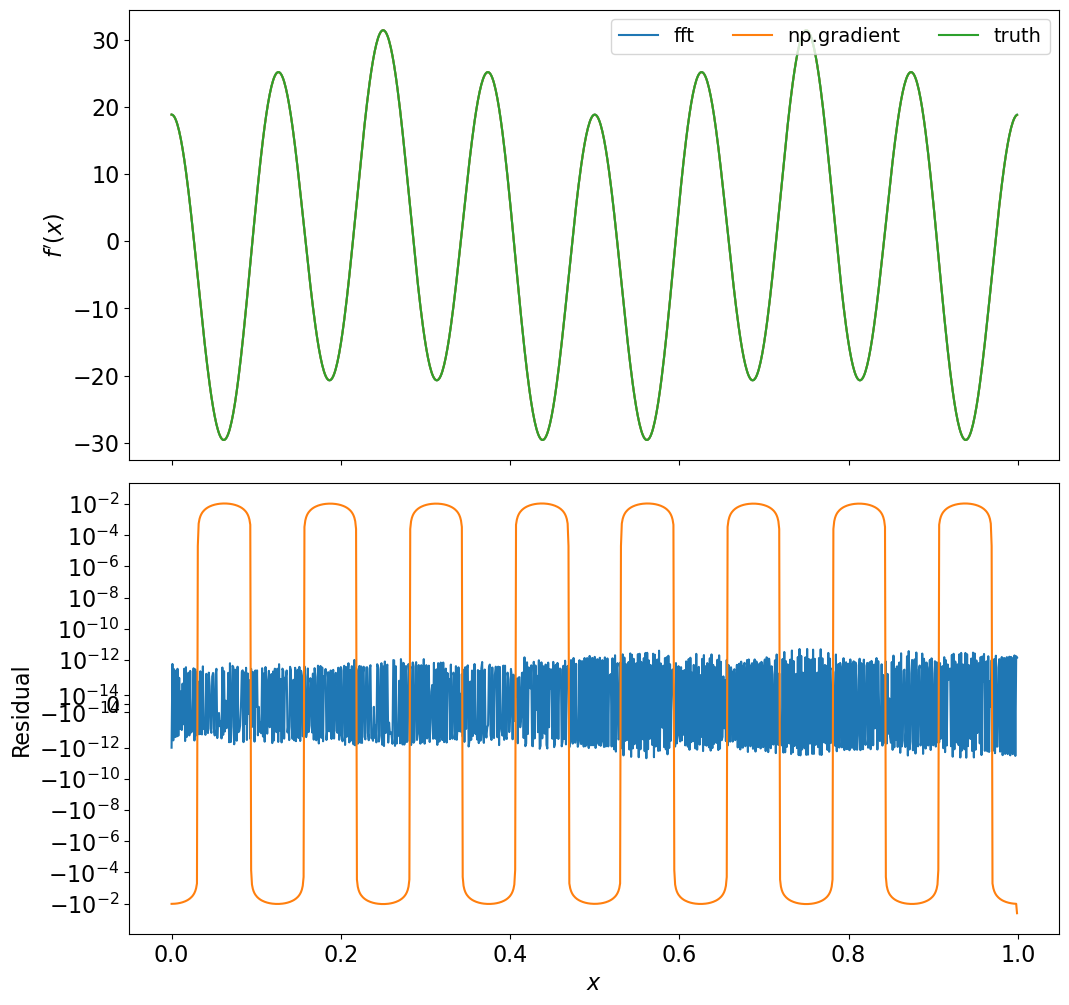

In [7]:
f,ax = plt.subplots(2,1,figsize=(12,12),sharex=True)
ax[0].plot(xx,dfft(ff,xx),label='fft')
ax[0].plot(xx,np.gradient(ff,xx),label='np.gradient')
ax[0].plot(xx,dfdx,label='truth')
ax[1].plot(xx,dfft(ff,xx)-dfdx)
ax[1].plot(xx,np.gradient(ff,xx)-dfdx)
ax[1].set_xlabel('$x$')
ax[0].set_ylabel("$f'(x)$")
ax[1].set_ylabel('Residual')
ax[1].set_yscale('symlog',linthresh=2e-14)
ax[0].legend(ncol=3,fontsize=14)
plt.subplots_adjust(hspace=0.05)

This spectral approach even works reasonably well for stiff functions that finite differences struggle with:

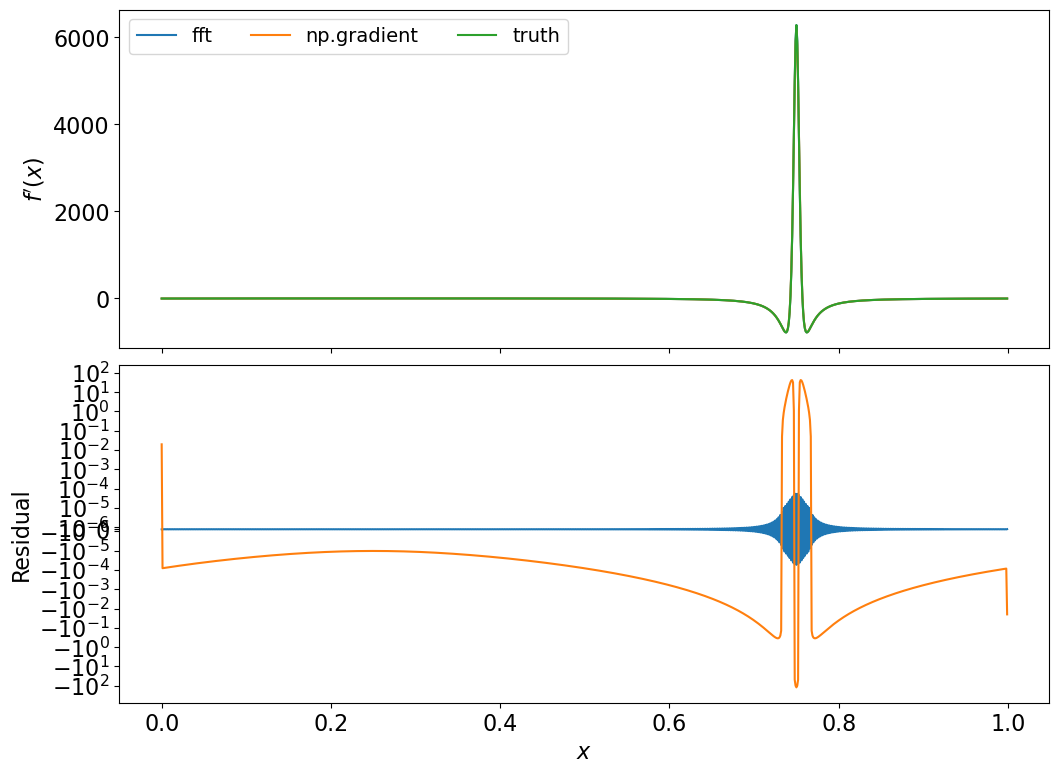

In [8]:
# a stiffer example:
ff = np.cos(2*np.pi*xx)/(1. + 0.999*np.sin(2*np.pi*xx))
dfdx =-2*np.pi*np.sin(2*np.pi*xx)/(1. + 0.999*np.sin(2*np.pi*xx)) \
      -np.cos(2*np.pi*xx)/(1. + 0.999*np.sin(2*np.pi*xx))**2*2*np.pi*0.999*np.cos(2*np.pi*xx)

f,ax = plt.subplots(2,1,figsize=(12,9),sharex=True)
ax[0].plot(xx,dfft(ff,xx),label='fft')
ax[0].plot(xx,np.gradient(ff,xx),label='np.gradient')
ax[0].plot(xx,dfdx,label='truth')
ax[1].plot(xx,dfft(ff,xx)-dfdx)
ax[1].plot(xx,np.gradient(ff,xx)-dfdx)
ax[1].set_xlabel('$x$')
ax[0].set_ylabel("$f'(x)$")
ax[1].set_ylabel('Residual')
ax[1].set_yscale('symlog',linthresh=1e-5)
ax[0].legend(ncol=3,fontsize=14)
plt.subplots_adjust(hspace=0.05)

However, it fails dramatically when the function being differentiated does not satisfy the same boundary conditions as the basis Fourier modes:

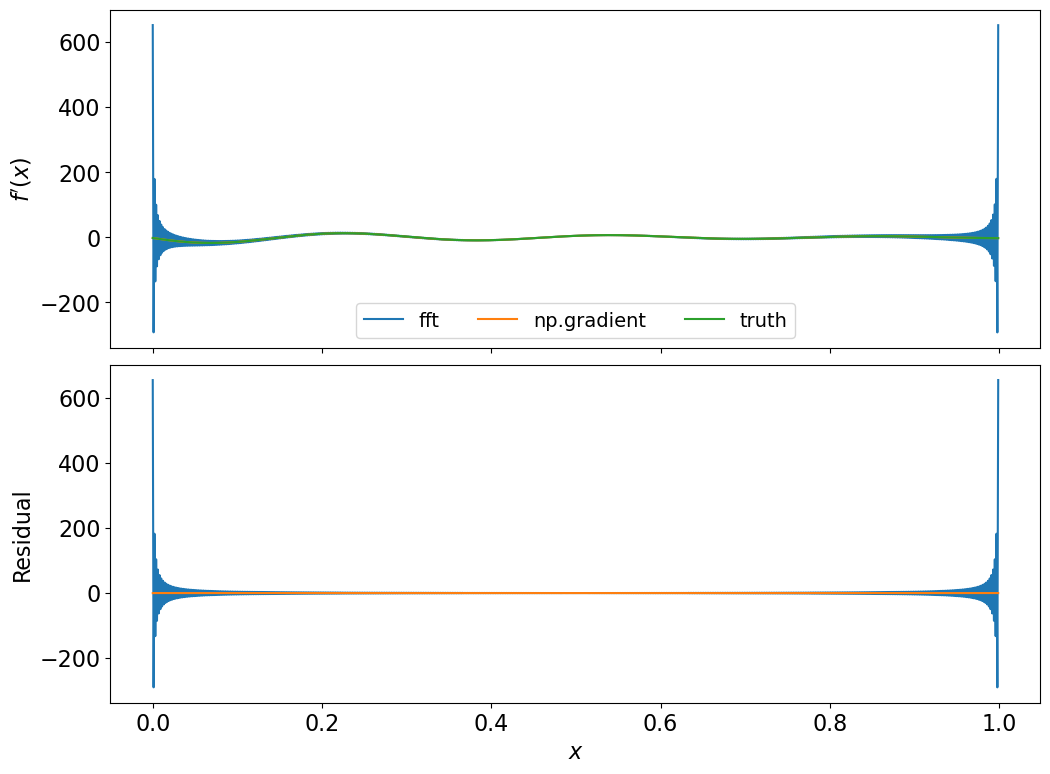

In [9]:
# a non-periodic function:
ff = np.cos(20*xx)*np.exp(-2*xx)
dfdx = -20*np.sin(20*xx)*np.exp(-2*xx) - 2*np.cos(20*xx)*np.exp(-2*xx)

f,ax = plt.subplots(2,1,figsize=(12,9),sharex=True)
ax[0].plot(xx,dfft(ff,xx),label='fft')
ax[0].plot(xx,np.gradient(ff,xx),label='np.gradient')
ax[0].plot(xx,dfdx,label='truth')
ax[1].plot(xx,dfft(ff,xx)-dfdx)
ax[1].plot(xx,np.gradient(ff,xx)-dfdx)
ax[1].set_xlabel('$x$')
ax[0].set_ylabel("$f'(x)$")
ax[1].set_ylabel('Residual')
ax[0].legend(ncol=3,fontsize=14)
plt.subplots_adjust(hspace=0.05)

The last case fails because we are attempting to expand the sampled function in a basis that does not satisfy the same boundary conditions (i.e., $f$ is not periodic). This is equivalent to power ``leakage'' that occurs when Fourier-transforming a signal over a sub-domain on which it is not periodic.

## Root finding

We often need to find the zeros (roots) of a function, i.e. the values $x$ where $f(x)=0$. One approach to this is called Newton-Raphson iteration. Like everything else we've done in this section, Newton's method starts with a Taylor expansion of $f$ around an arbitrary $x$:

\begin{equation}
    f(x+\delta)
    =f(x) + f'(x)\delta +...+\mathcal{O}(\delta^2),
\end{equation}

where $\delta$ is some small parameter. The goal is to find $\delta$ such that $f(x+\delta)$ tends to zero. Ignoring quadratic and higher powers of $\delta$ and setting $f(x+\delta)=0$, the Taylor expansion above leads to $\delta = -f(x)/f'(x)$. This suggests an iterative approach: at a given $x_i$, compute the next step toward a root from

$$x_{i+1}=x_i+\delta_i=x_i-\frac{f(x_i)}{f'(x_i)}.$$

Note that if your function has multiple roots, the one returned by the Newton iteration above will depend on the initial x0 provided. 

## Exercise 5

Your homework asks you to write a function that performs a Newton iteration on a provided function. Parts of the session later on today will depend on your understanding of this approach, so ask me any questions you may have about that problem now.

## Scipy options

The library scipy.optimize has a few other functions for root-finding with a bit more functionality (in particular scipy.optimize.newton and scipy.optimize.brentq)